<a href="https://colab.research.google.com/github/Steriva/MfM_Assignment/blob/main/exe02d_NN_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [ ]:
reset-f

### Loading packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm 
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split


from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from scipy.integrate import odeint
from google.colab import files

import tqdm.notebook
# import tqdm.tqdm (uncomment this when executing as a .py)

rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Neural Network for the Lorenz equation
At first let us present the Lorenz equations
\begin{equation}
\left\{
\begin{split}
\frac{\partial x}{\partial t} &= \sigma(y-x)\\
\frac{\partial y}{\partial t} &= x\cdot (\rho-z)-y\\
\frac{\partial z}{\partial t} &= x\cdot y - \beta \, z
\end{split}
\right.
\end{equation}
given $[0, T]$ the time domain. 

The parameters are equal to
\begin{equation}
\sigma = 10\qquad \beta = \frac{8}{3}\qquad \rho = [10, 28, 35]^T
\end{equation}

The system of equations is solved considering 100 different IC, randomly generated in $[-15, 15]$.

The input/output training data are stored in a matrix solution, whose dimensions are 
\begin{equation}
100\cdot \left[\mbox{len}(t)-1\right]\cdot \left[\mbox{len}(\rho)\right]\times 3
\end{equation}

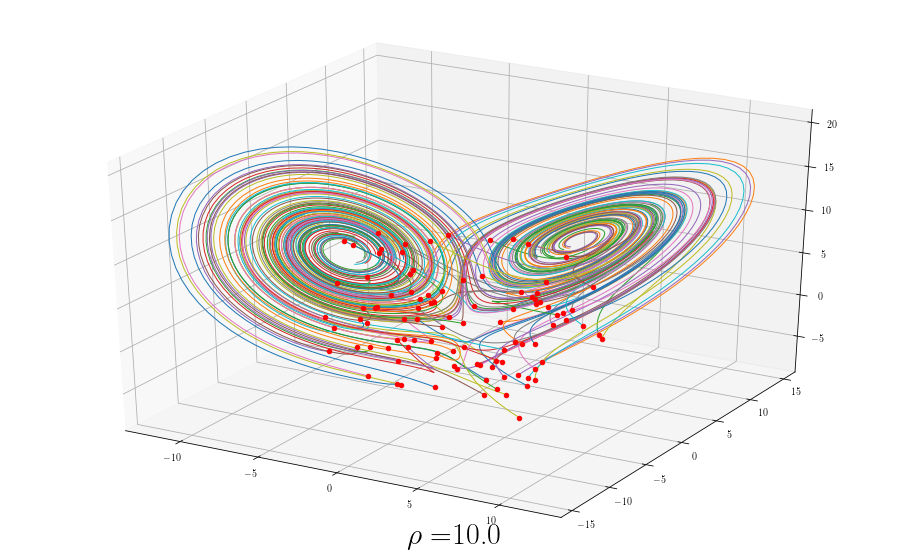

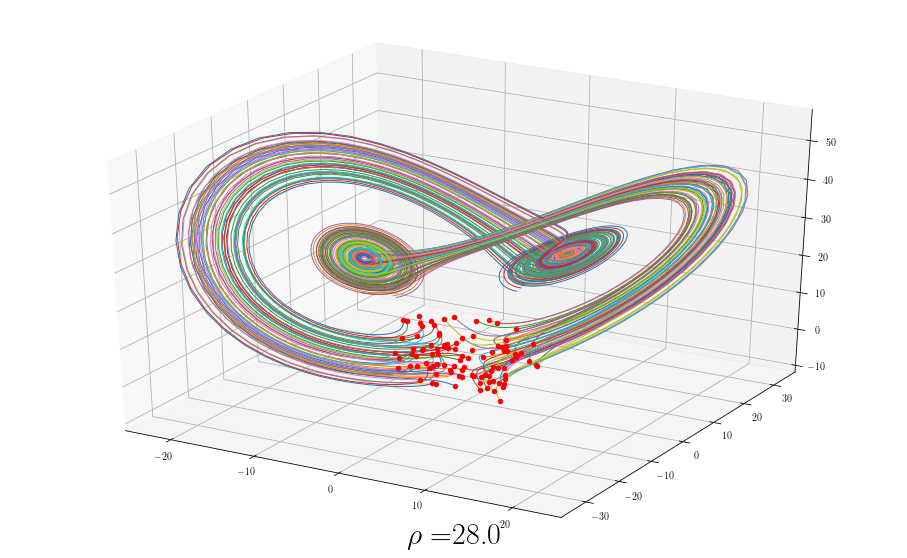

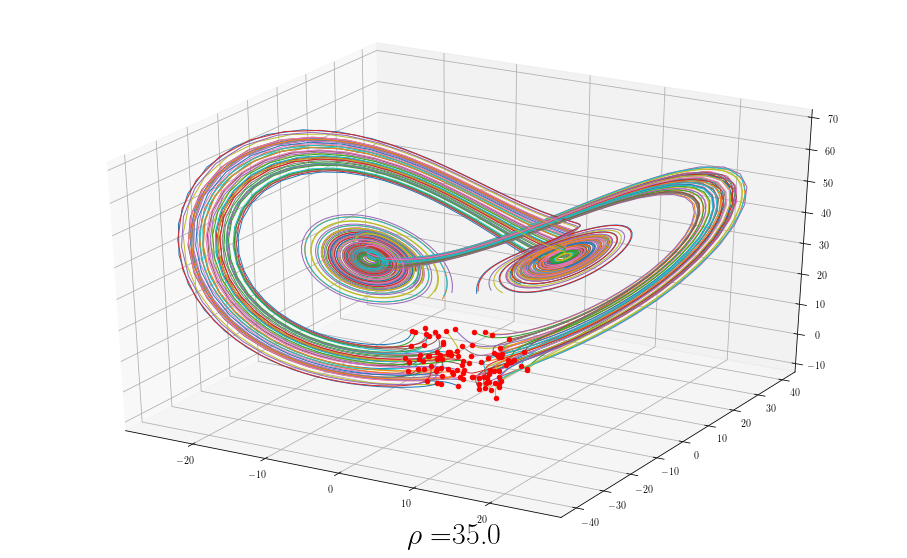

In [ ]:
## Generating the Lorenz System training data

dt = 0.01 # to lower computational cost
T = 2
t = np.arange(0, T+dt, dt)

# Lower and Upper Bound for IC
lb = -7.5
ub =  7.5

beta = 8/3
sigma = 10
rhoVec = np.array([10., 28., 35.])

numTraj = 100

nn_input = np.zeros((numTraj *(len(t)-1) * len(rhoVec),4)) # 3 coordinates + 1 parameter rho
nn_output = np.zeros((numTraj *(len(t)-1) * len(rhoVec),4)) 

np.random.seed(123)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

for rho_j in range(len(rhoVec)):
  rho = rhoVec[rho_j]
  ax = plt.figure().add_subplot(projection='3d')

  def lorenz_deriv(x_y_z, t0, rho=rho, sigma=sigma, beta=beta):
      x, y, z = x_y_z
      return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

  x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                    for x0_j in x0])
  for j in range(numTraj):
    nn_input[ j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,:-1] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,:-1] = x_t[j,1:,:]
    nn_input[ j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,-1]  = rhoVec[rho_j]
    nn_output[j*(len(t)-1) + rho_j * (len(t) - 1) * numTraj:(j+1)*(len(t)-1)+ rho_j * (len(t) - 1) * numTraj,-1]  = rhoVec[rho_j]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
    plt.title( r'$\rho = $' + str(rho), fontsize = 30 )

## Training the Neural Network


Let's build the model at first with 2 layers (the input and output with linear activation function are not counted), with 5 neurons each. 'relu' activation function is adopted.

The loss function is the Mean Square Error (MSE) and the optimizer is 'adam'.

In [ ]:
NN_model = keras.models.Sequential()

NN_model.add(layers.Dense(16, input_dim = 4, activation='sigmoid', name='Input')) # input layer
NN_model.add(layers.Dense(16, activation='relu'))
NN_model.add(layers.Dense(16, activation='relu'))
NN_model.add(layers.Dense(4,  activation='linear'))

learningRate = keras.optimizers.schedules.PiecewiseConstantDecay( [187500, 375000, 750000], [1e-3, 1e-4, 5e-5, 1e-5])
NN_model.compile( loss='mse', 
                  optimizer=keras.optimizers.Adam(learning_rate = learningRate) )

Now, we can train out net with 500 epochs.

In [ ]:
History = NN_model.fit(nn_input, nn_output, epochs=500, batch_size = 32 )

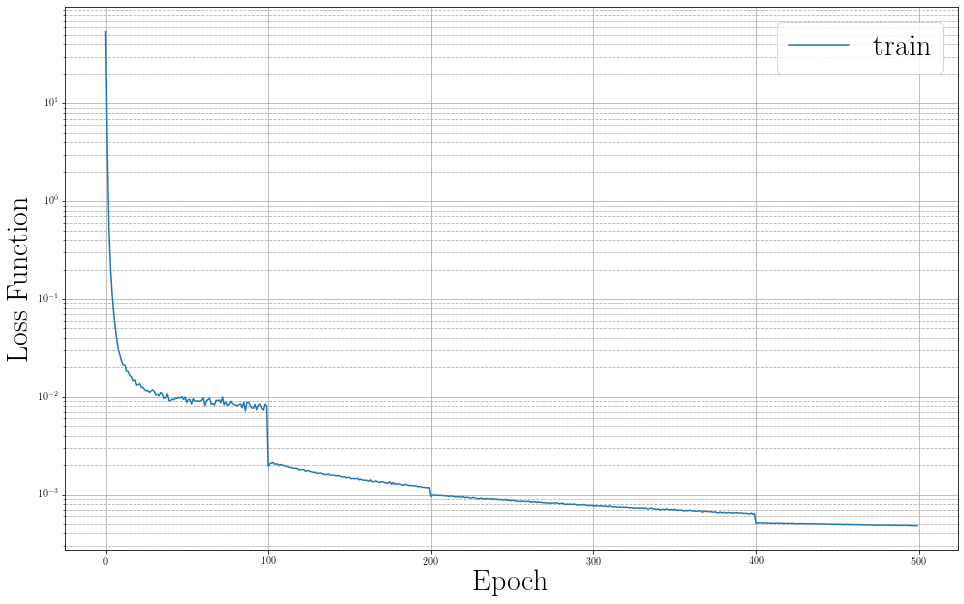

In [ ]:
plt.figure()
plt.semilogy(History.history['loss'])
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.ylabel('Loss Function',fontsize=30)
plt.xlabel('Epoch',fontsize=30)
plt.legend(['train', 'test'], loc='upper right',fontsize=30)
plt.show()

The trained model will be saved for later use

In [ ]:
# serialize model to JSON
model_json = NN_model.to_json()
with open("LorenzNNmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
NN_model.save_weights("LorenzNNmodel.h5")

files.download("LorenzNNmodel.json")
files.download("LorenzNNmodel.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading the model, to check everything went well

In [ ]:
# load json and create model
json_file = open('LorenzNNmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
NN_model = model_from_json(loaded_model_json)
# load weights into new model
NN_model.load_weights("LorenzNNmodel.h5")
NN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 16)                80        
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 4)                 68        
                                                                 
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


# Check training
Let us consider $\rho= 28$ and let's see how the prediction of NNs is with respect to the ODE-solution.

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

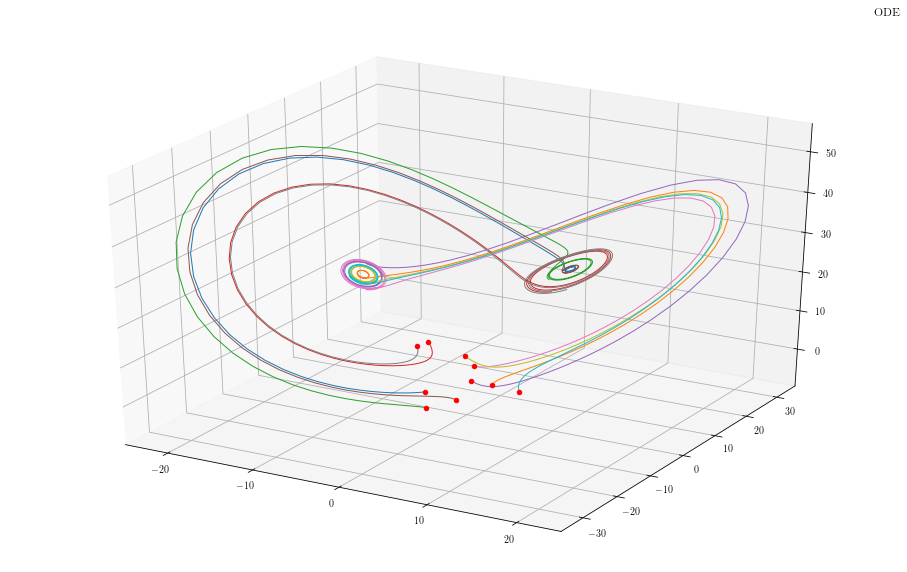

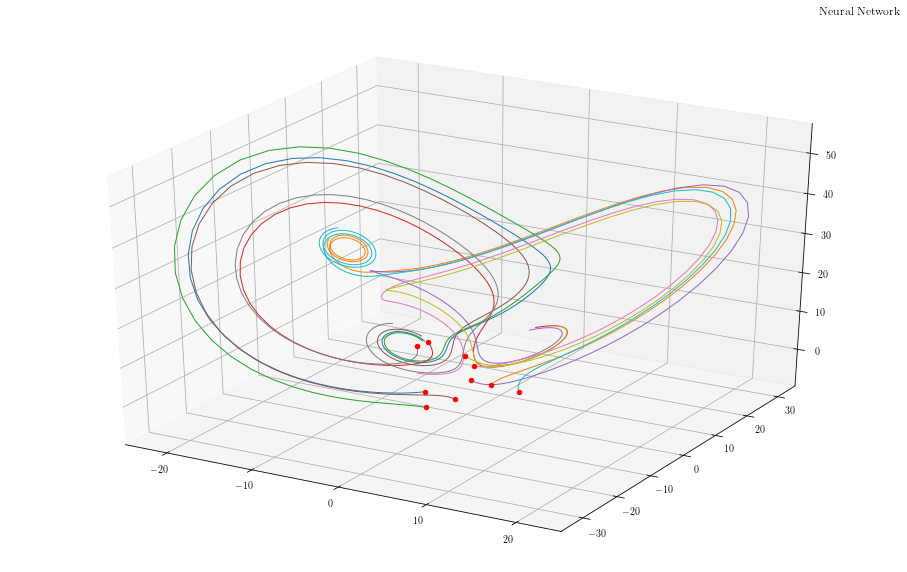

In [ ]:
rhoInterp = 28

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

InterpNN = np.zeros((numTraj, len(t), 4))

InterpNN[:,0,:-1] = x0[:]
InterpNN[:,0,-1] = rhoInterp


## ODE plot
ax = plt.figure().add_subplot(projection='3d')

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  ax.plot(xInterp, yInterp, zInterp,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE', loc = 'right')
  
## NN plot
ax = plt.figure().add_subplot(projection='3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 4])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:-1].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network', loc = 'right')
  progressBar.update(1)

# Interpolation
Let us consider $\rho= 17$ and let's see how the prediction of NNs is with respect to the ODE-solution

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

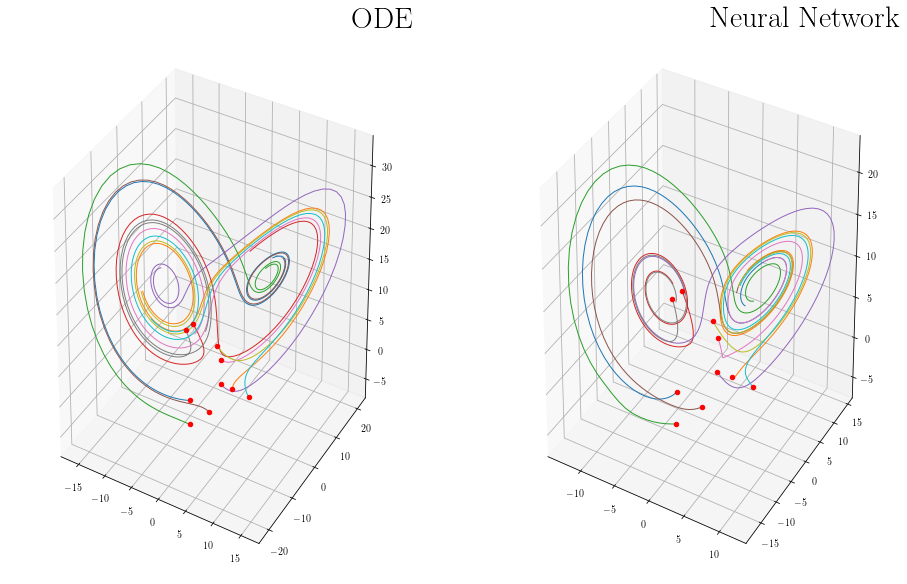

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rhoInterp = 17

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])


InterpNN = np.zeros((numTraj, len(t), 4))

InterpNN[:,0,:-1] = x0[:]
InterpNN[:,0,-1] = rhoInterp


## ODE plot
figInt = plt.figure()
ax = figInt.add_subplot(1,2,1, projection = '3d')

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  ax.plot(xInterp, yInterp, zInterp,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE', fontsize = 30, loc='right')
  
## NN plot
ax = figInt.add_subplot(1,2,2, projection = '3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 4])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:-1].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network', fontsize = 30, loc='right')
  progressBar.update(1)

plt.show()

figInt.savefig('NN_LorenzInterpolation.pdf', format='pdf', dpi=600, bbox_inches='tight')

files.download('NN_LorenzInterpolation.pdf')

In this part a single trajectory will be plotted in 2D.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

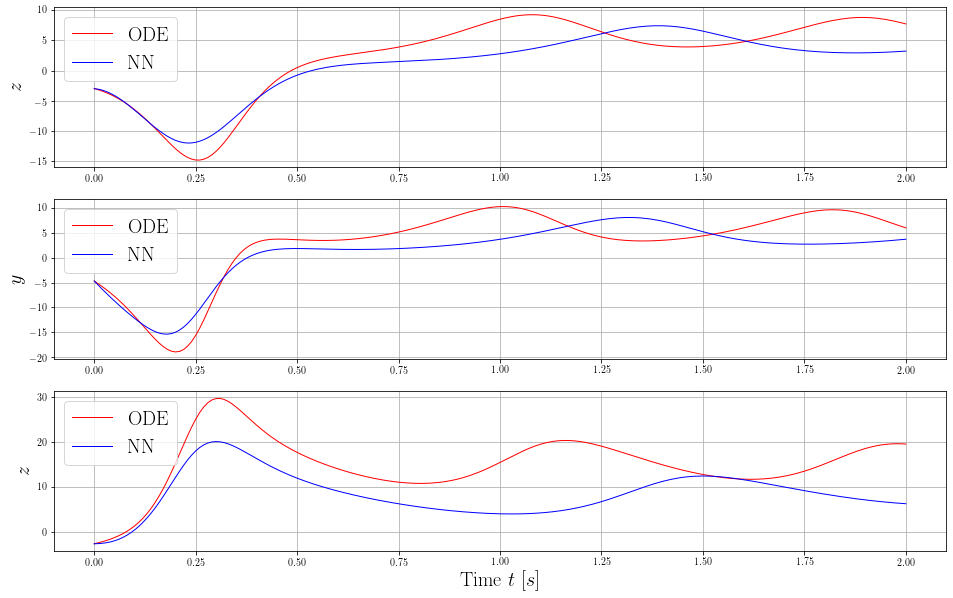

In [24]:
rhoInterp = 17

numTraj = 1

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])


InterpNN = np.zeros((numTraj, len(t), 4))

InterpNN[:,0,:-1] = x0[:]
InterpNN[:,0,-1] = rhoInterp


## ODE plot
figInt = plt.figure()

for traj in range(numTraj):

  xInterp, yInterp, zInterp = x_t[traj,:,:].T
  plt.subplot(3,1,1)
  plt.plot(t,xInterp,linewidth=1, color = 'r', label = 'ODE')
  plt.subplot(3,1,2)
  plt.plot(t,yInterp,linewidth=1, color = 'r', label = 'ODE')
  plt.subplot(3,1,3)
  plt.plot(t,zInterp,linewidth=1, color = 'r', label = 'ODE')


for traj in range(numTraj):  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(InterpNN[traj, time, :], [1, 4])
    tmpOUT = NN_model.predict(tmpIN)
    InterpNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = InterpNN[traj,:,:-1].T
  plt.subplot(3,1,1)
  plt.plot(t,xNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$z$', fontsize = 20)
  plt.subplot(3,1,2)
  plt.plot(t,yNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$y$', fontsize = 20)
  plt.subplot(3,1,3)
  plt.plot(t,zNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$z$', fontsize = 20)
  plt.xlabel(r'Time $t$ $[s]$', fontsize = 20)


for jj in range(1,4):
  plt.subplot(3,1,jj)
  plt.legend(fontsize=20)
  plt.grid(which='major',linestyle='-')
  plt.grid(which='minor',linestyle='--')

plt.show()

# Extrapolation
Let us consider $\rho= 40$ and let's see how the prediction of NNs is with respect to the ODE-solution

Predicting the solution with NN:   0%|          | 0/10 [00:00<?, ?it/s]

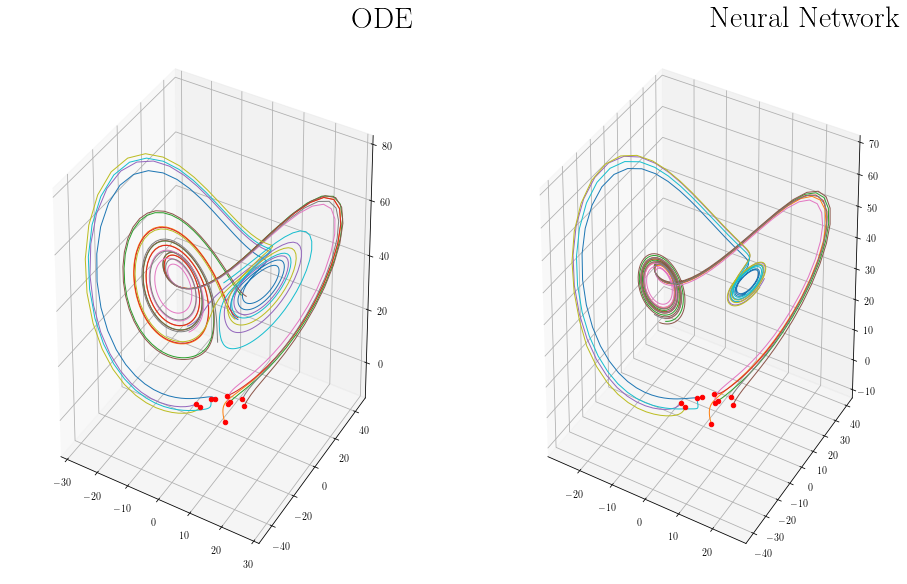

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rhoExtrap = 40

numTraj = 10

def lorenz_deriv(x_y_z, t0, rho=rhoExtrap, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(100)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

ExtrapNN = np.zeros((numTraj, len(t), 4))

ExtrapNN[:,0,:-1] = x0[:]
ExtrapNN[:,0,-1] = rhoExtrap


## ODE plot
figExtrp = plt.figure()
ax = figExtrp.add_subplot(1,2,1, projection = '3d')

for traj in range(numTraj):

  xExtrap, yExtrap, zExtrap = x_t[traj,:,:].T
  ax.plot(xExtrap, yExtrap, zExtrap,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('ODE', fontsize = 30, loc='right')
  
## NN plot
ax = figExtrp.add_subplot(1,2,2, projection = '3d')

progressBar = tqdm.notebook.tqdm(desc="Predicting the solution with NN", total=numTraj)

for traj in range(numTraj):
  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(ExtrapNN[traj, time, :], [1, 4])
    tmpOUT = NN_model.predict(tmpIN)
    ExtrapNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = ExtrapNN[traj,:,:-1].T
  ax.plot(xNN, yNN, zNN,linewidth=1)
  ax.scatter(x0[traj,0],x0[traj,1],x0[traj,2],color='r')  
  plt.title('Neural Network', fontsize = 30, loc='right')
  progressBar.update(1)

plt.show()

figExtrp.savefig('NN_LorenzExtrapolation.pdf', format='pdf', dpi=600, bbox_inches='tight')

files.download('NN_LorenzExtrapolation.pdf')

In this part a single trajectory will be plotted in 2D.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

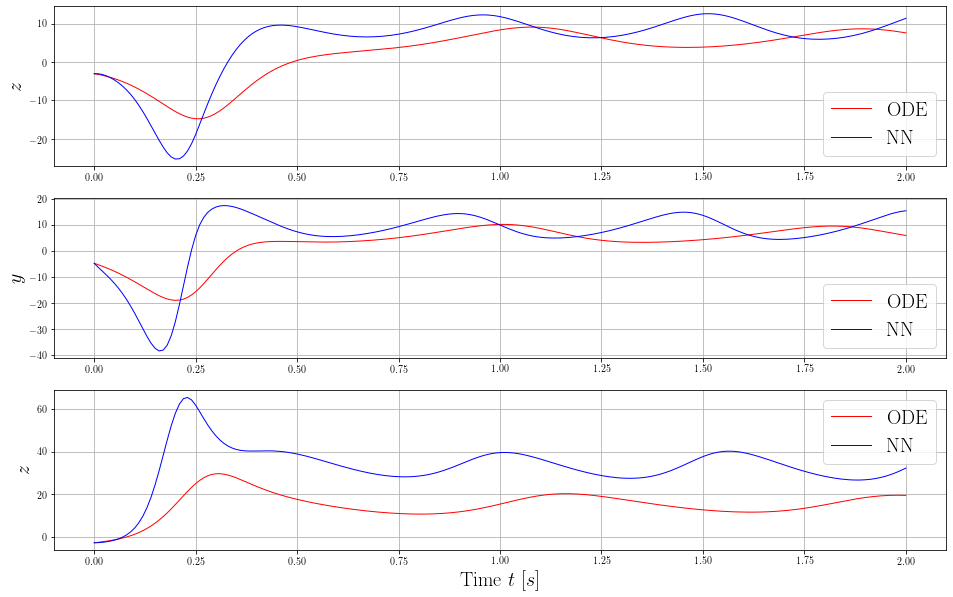

In [26]:
rhoExtrap = 40

numTraj = 1

def lorenz_deriv(x_y_z, t0, rho=rhoInterp, sigma=sigma, beta=beta):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(60)
x0 = lb + (ub-lb) * np.random.random((numTraj, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

ExtrapNN = np.zeros((numTraj, len(t), 4))

ExtrapNN[:,0,:-1] = x0[:]
ExtrapNN[:,0,-1] = rhoExtrap



## ODE plot
figInt = plt.figure()

for traj in range(numTraj):

  xExtrap, yExtrap, zExtrap = x_t[traj,:,:].T
  plt.subplot(3,1,1)
  plt.plot(t,xExtrap,linewidth=1, color = 'r', label = 'ODE')
  plt.subplot(3,1,2)
  plt.plot(t,yExtrap,linewidth=1, color = 'r', label = 'ODE')
  plt.subplot(3,1,3)
  plt.plot(t,zExtrap,linewidth=1, color = 'r', label = 'ODE')


for traj in range(numTraj):  
  for time in range(len(t)-1):
    
    tmpIN = np.reshape(ExtrapNN[traj, time, :], [1, 4])
    tmpOUT = NN_model.predict(tmpIN)
    ExtrapNN[traj, time + 1, :] = tmpOUT

  xNN, yNN, zNN = ExtrapNN[traj,:,:-1].T
  plt.subplot(3,1,1)
  plt.plot(t,xNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$z$', fontsize = 20)
  plt.subplot(3,1,2)
  plt.plot(t,yNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$y$', fontsize = 20)
  plt.subplot(3,1,3)
  plt.plot(t,zNN,linewidth=1, color = 'b', label = 'NN')
  plt.ylabel(r'$z$', fontsize = 20)
  plt.xlabel(r'Time $t$ $[s]$', fontsize = 20)


for jj in range(1,4):
  plt.subplot(3,1,jj)
  plt.legend(fontsize=20)
  plt.grid(which='major',linestyle='-')
  plt.grid(which='minor',linestyle='--')

plt.show()